In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from multiprocessing import Pool
from astropy.coordinates import SkyCoord

# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import random

In [2]:
 # Importing the dataset containing optical clusters
df = pd.read_csv('data/ard_not_adv.csv', skiprows = 0)
df = df[df.amf_sn!=0]
df.sort_values(by=['amf_rh'],ascending=False)

,Unnamed: 0,Unnamed: 0.1,amf_no,amf_ra,amf_dec,amf_z,amf_lk,amf_rh,amf_r200,amf_rc,...,red_id,whl_id,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster
0,0,0,5.0,260.6324,32.1398,0.2252,222.1219,200.7117,1.784,0.625,...,RMJ172227.2+320757.2,J172227.2+320757,31.846666,55.602221,24.655148,-0.000048,1.978746,-0.000006,0.001062,1
1,1,1,7.0,250.1485,46.6917,0.2248,225.9874,182.3373,1.725,0.495,...,RMJ164019.8+464241.5,J164019.8+464242,41.429880,72.599428,44.674799,-0.000269,1.196847,-0.000215,0.000722,1
2,3,3,10.0,203.1873,50.5346,0.3110,164.8704,179.1883,1.663,0.422,...,RMJ133238.4+503336.0,J133252.1+503134,65.305106,107.103759,25.696075,-0.000124,1.019871,-0.000129,0.000580,1
3,4,4,12.0,350.2432,29.2029,0.5231,165.0015,174.7108,1.518,0.390,...,RMJ232104.1+291134.5,J232104.1+291134,-29.646780,100.211077,13.793623,0.000047,4.913466,0.000091,0.001929,1
4,5,5,13.0,139.4938,51.7236,0.2574,169.5809,172.6889,1.676,0.199,...,RMJ091753.4+514337.5,J091753.4+514338,43.387615,166.090009,20.839521,0.000029,1.074994,0.000060,0.000894,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21001,21533,21533,54265.0,117.7965,28.4314,0.4498,21.3133,20.0019,0.721,0.090,...,-9999,J075110.0+282537,24.760679,192.272829,0.235375,-0.000085,1.742793,-0.000074,0.000728,1
21002,21534,21534,54266.0,10.2234,16.4729,0.3325,7.5789,20.0018,0.754,0.420,...,-9999,J004043.6+162754,-46.323866,119.270217,1.128670,-0.000071,1.821485,-0.000079,0.000611,1
21003,21535,21535,54272.0,332.5373,16.8053,0.2720,19.0528,20.0008,0.774,0.059,...,-9999,J221009.3+165449,-31.180104,76.542726,0.327218,-0.000112,2.181500,-0.000118,0.000789,1
21004,21536,21536,54273.0,321.0614,-5.5885,0.4036,7.3319,20.0008,0.734,0.260,...,-9999,J212412.8-053647,-36.312474,46.861993,0.906488,0.000283,3.162386,0.000297,0.001527,1


In [3]:
# Importing the dataset containing non-clusters
df2 = pd.read_csv('data/fake_data.csv', skiprows = 0)

In [4]:
# Combine real and fake data
df3 = df.append(df2, ignore_index=True)

---

# Predicting signal in one frequency based on signal in others

#### Training

In [5]:
# From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
# 50 percent of the sample has richness over 27, use the richer sample for training
X = df[df.amf_rh>27][['intensity100', 'intensity353']]
y = df[df.amf_rh>27]['intensity143']

regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Validation

In [6]:
# Build array of predictions for the half of the sample not used in training
X_val = df[df.amf_rh<27][['intensity100', 'intensity353']]

intensity143 = [regr.predict([[i,j]]) for i, j in X_val.values]

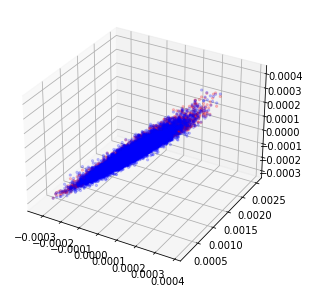

In [7]:
# Plot actual data vs predictions in three dimensions
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df[df.amf_rh<27]['intensity100'], df[df.amf_rh<27]['intensity353'], df[df.amf_rh<27]['intensity143'],s=5,c='b', alpha=0.2)
ax.scatter(df[df.amf_rh<27]['intensity100'], df[df.amf_rh<27]['intensity353'], intensity143, s=5, c='r', alpha=0.2)
plt.show()

---

# Classification of clusters vs non clusters

In [8]:
# From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
# 50 percent of the sample has richness over 27, use the richer sample for training
X = df[['intensity100', 'intensity143', 'intensity353']]
X_f = df2[['intensity100', 'intensity143', 'intensity353']]
X2 = df3[['intensity100', 'intensity143', 'intensity353']]
y2 = df3['cluster']

regr = linear_model.LinearRegression()
regr.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
cluster = np.array([regr.predict([[i,j,k]]) for i, j, k in X.values]).flatten()

In [10]:
no_cluster = np.array([regr.predict([[i,j,k]]) for i, j, k in X_f.values]).flatten()

(0.0, 4.0)

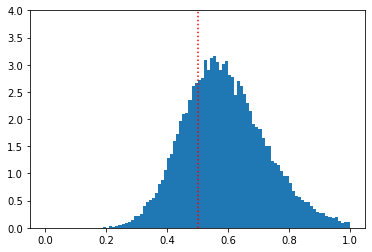

In [11]:
plt.hist(cluster,bins=100,range=(0,1),density=True)
plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
plt.ylim(0,4)

(0.0, 9.0)

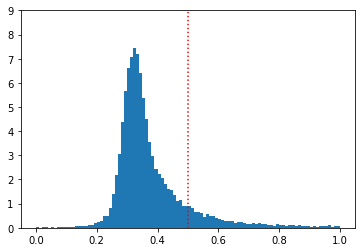

In [12]:
plt.hist(no_cluster,bins=100,range=(0,1),density=True)
plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
plt.ylim(0,9)

---

# Identification of clusters

In [13]:
# Csv importer wrapped in a function that can be mapped for parallelization
def read_csv(filename):
    return pd.DataFrame(np.loadtxt(filename,delimiter=', ')).T

In [14]:
links100 = ['data/results100_1.csv','data/results100_2.csv','data/results100_3.csv',
         'data/results100_4.csv','data/results100_5.csv','data/results100_6.csv',
         'data/results100_7.csv','data/results100_8.csv','data/results100_9.csv',
         'data/results100_10.csv']
links143 = ['data/results143_1.csv','data/results143_2.csv','data/results143_3.csv',
         'data/results143_4.csv','data/results143_5.csv','data/results143_6.csv',
         'data/results143_7.csv','data/results143_8.csv','data/results143_9.csv',
         'data/results143_10.csv']
links353 = ['data/results353_1.csv','data/results353_2.csv','data/results353_3.csv',
         'data/results353_4.csv','data/results353_5.csv','data/results353_6.csv',
         'data/results353_7.csv','data/results353_8.csv','data/results353_9.csv',
         'data/results353_10.csv']

In [15]:
for links in [links100,links143,links353]:
    with Pool(processes=5) as pool: 
        df_list = pool.map(read_csv, links)
        if links==links100:
            data100 = pd.concat(df_list, ignore_index=True)
        if links==links143:
            data143 = pd.concat(df_list, ignore_index=True)
        if links==links353:
            data353 = pd.concat(df_list, ignore_index=True)

In [16]:
# pl143 = hp.read_map('HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits')

In [17]:
# Convert the RA and DEC to galactic coordinates
c = SkyCoord(data100[1],data100[2],frame='icrs',unit='deg')
data100['glat'] = c.galactic.b.degree
data100['glon'] = c.galactic.l.degree

c = SkyCoord(data143[1],data143[2],frame='icrs',unit='deg')
data143['glat'] = c.galactic.b.degree
data143['glon'] = c.galactic.l.degree

c = SkyCoord(data353[1],data353[2],frame='icrs',unit='deg')
data353['glat'] = c.galactic.b.degree
data353['glon'] = c.galactic.l.degree

In [18]:
# initialize data of lists.
data_all = {'int100':data100[0],
            'int143':data143[0],
            'int353':data353[0]}
 
intensity_all = pd.DataFrame(data_all)

In [19]:
cluster_prob = np.array([regr.predict([[i,j,k]]) for i, j, k in intensity_all[['int100', 'int143', 'int353']].values]).flatten()

In [20]:
data100['cluster']=cluster_prob

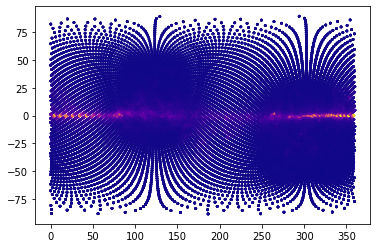

In [21]:
# hp.mollview(pl143,norm='hist',cmap='Greys',coord=['G'],title='Masked S/N map')
# hp.visufunc.projscatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',lonlat=True,s=10)
plt.scatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',s=3)